In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [2]:
from typing import Iterable, NamedTuple
from poclaps.train.ckpt_cb import load_ckpt
from poclaps.train.ppo import make_train as make_ppo_train
from poclaps.train.ppo import FlattenObservationWrapper, LogWrapper
from poclaps import environments

from pathlib import Path
import yaml


# run_dir = Path('outputs/2024-06-11/19-46-55')
run_dir = Path('outputs/2024-06-14/15-39-35/')
run_dir2 = Path('outputs/2024-06-15/00-58-28/')


def load_config(run_dir):
    with open(f'{run_dir}/.hydra/config.yaml') as f:
        config = yaml.safe_load(f)
        config['output_dir'] = run_dir
    return config

config = load_config(run_dir)
config2 = load_config(run_dir2)

init_state, train_fn = make_ppo_train(config)

print(config)

def load_pretrained_policy(run_dir, config, ckpt_step=195):
    init_state, _ = make_ppo_train(config)
    ckpt = load_ckpt(run_dir / 'checkpoints', ckpt_step, init_state)
    train_state, *_ = ckpt

    def pretrained_policy(obs):
        return train_state.apply_fn(train_state.params, obs)

    return pretrained_policy

pretrained_policy = load_pretrained_policy(run_dir, config)
pretrained_policy2 = load_pretrained_policy(run_dir2, config2)
print('Loaded policy checkpoint.')

env, env_params = environments.make(config["env_name"],
                                    **config.get('env_kwargs', {}))
env = FlattenObservationWrapper(env)
env = LogWrapper(env)


import jax
from flax import struct
from chex import Array
import jax.numpy as jnp

I0000 00:00:1719350014.353666 3129485 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


{'algorithm': 'PPO', 'learning_rate': 0.00025, 'num_envs': 4, 'num_steps': 128, 'total_timesteps': 100000.0, 'update_epochs': 4, 'num_minibatches': 4, 'gamma': 0.99, 'gae_lambda': 0.95, 'clip_eps': 0.2, 'ent_coef': 0.01, 'vf_coef': 0.5, 'max_grad_norm': 0.5, 'activation': 'tanh', 'anneal_lr': True, 'seed': 0, 'env_name': 'SimpleGridWorld-v0', 'env_kwargs': {'grid_size': 5, 'max_steps_in_episode': 20}, 'wandb_entity': 'drcope', 'wandb_project': 'ppo-gridworld-example', 'wandb_mode': 'online', 'output_dir': PosixPath('outputs/2024-06-14/15-39-35'), 'num_updates': 195.0, 'minibatch_size': 128}
Loaded policy checkpoint.


In [3]:
import numpy as np
from poclaps.simple_gridworld_game import (
    EnvState as SimpleGridWorldEnvState,
    EnvParams as SimpleGridWorldEnvParams,
)


class Transition(NamedTuple):
    env_state: struct.PyTreeNode
    done: Array
    action: Array
    message: Array
    reward: Array
    log_prob: Array
    obs: Array
    info: dict
    episode_id: int


class SimpleGridWorldCommPolicy:
    """
    """

    def __init__(self, seed: int, env_params: SimpleGridWorldEnvParams):
        self.seed = seed
        self.env_params = env_params
        self.n_msgs = env_params.grid_size * env_params.grid_size
        grid_indices = list(range(self.n_msgs))
        np.random.seed(seed)
        np.random.shuffle(grid_indices)
        self.msg_map = dict(enumerate(grid_indices))
        self.mapping = jnp.array(list(self.msg_map.values()))

    def get_msg(self, goal_pos: jnp.array) -> int:
        pos_idx = goal_pos[0] * self.env_params.grid_size + goal_pos[1]
        return self.mapping[pos_idx]

comm_policy = SimpleGridWorldCommPolicy(0, env_params)


def rollout_with_msgs(env, policy, comm_policy, steps, n_envs=4, rng=None, rollout_state=None):

    @jax.jit
    def _env_step(rollout_state, _):
        env_state, last_obs, rng, ep_ids = rollout_state

        # SELECT ACTION
        rng, _rng = jax.random.split(rng)
        pi, _ = policy(last_obs)
        action = pi.sample(seed=_rng)
        log_prob = pi.log_prob(action)

        # STEP ENV
        rng, _rng = jax.random.split(rng)
        rng_step = jax.random.split(_rng, n_envs)
        obsv, env_state, reward, done, info = jax.vmap(
            env.step, in_axes=(0, 0, 0, None)
        )(rng_step, env_state, action, env_params)
        ep_ids = jnp.where(done, ep_ids + n_envs, ep_ids)

        msg = jax.lax.map(
            lambda g: comm_policy.get_msg(g),
            env_state.env_state.goal_pos
        )

        transition = Transition(
            env_state, done, action, msg, reward, log_prob, last_obs, info, ep_ids
        )
        rollout_state = (env_state, obsv, rng, ep_ids)
        return rollout_state, transition

    if rollout_state is None:
        if rng is None:
            rng = jax.random.PRNGKey(0)
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, n_envs)
        obsv, env_state = jax.vmap(env.reset,
                                   in_axes=(0, None))(reset_rng, env_params)
        ep_ids = jnp.arange(n_envs)
        rollout_state = (env_state, obsv, rng, ep_ids)

    rollout_state, traj_batch = jax.lax.scan(
        _env_step, rollout_state, None, steps
    )

    metrics = {}

    metrics['mean_reward'] = (
        (traj_batch.info["returned_episode_returns"] * traj_batch.info["returned_episode"]).sum()
        / traj_batch.info["returned_episode"].sum()
    )

    metrics['mean_episode_len'] = (
        (traj_batch.info["returned_episode_lengths"] * traj_batch.info["returned_episode"]).sum()
        / traj_batch.info["returned_episode"].sum()
    )

    metrics['n_episodes'] = traj_batch.info["returned_episode"].sum()

    return rollout_state, traj_batch, metrics


rollout_state, traj_batch, metrics = rollout_with_msgs(env, pretrained_policy, comm_policy, 500)

In [4]:
import flax.linen as nn
import jax
import functools


class ScannedRNN(nn.Module):
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(*rnn_state.shape),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(features=self.hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (n_envs, hidden_size))


In [5]:
import flax.linen as nn
import jax


class ScannedBiRNN(nn.Module):
    hidden_size: int = 128

    @nn.compact
    def __call__(self, carry, inputs):
        forward_carry, backward_carry = carry
        forward_carry, forward_embs = ScannedRNN(self.hidden_size)(
            forward_carry, inputs
        )
        feats, resets = inputs
        backward_inputs = (feats[::-1], resets[::-1])
        backward_carry, backward_embs = ScannedRNN(self.hidden_size)(
            backward_carry, backward_inputs
        )
        carry = (forward_carry, backward_carry)
        embs = jnp.concatenate([forward_embs, backward_embs], axis=-1)
        return carry, embs

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        return (
            ScannedRNN.initialize_carry(n_envs, hidden_size),
            ScannedRNN.initialize_carry(n_envs, hidden_size)
        )

In [48]:
class ObsModel(nn.Module):
    obs_size: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs: tuple):
        actions, messages, dones, *_ = inputs
        feats = jnp.concatenate([actions, messages], axis=-1)
        # *_, dones, obs = inputs
        # feats = obs
        x = nn.Dense(self.hidden_size)(feats)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        _, n_envs, _ = x.shape
        carry = ScannedBiRNN.initialize_carry(n_envs, self.hidden_size)
        bi_lstm = ScannedBiRNN(self.hidden_size)
        _, x = bi_lstm(carry, (x, dones))
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        obs_preds = nn.Dense(self.obs_size)(x)
        obs_preds = nn.sigmoid(obs_preds)
        return obs_preds

In [49]:
N_ACTIONS = 5
actions_1h = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
msgs_1h = jax.nn.one_hot(traj_batch.message, comm_policy.n_msgs)

hidden_size = 128
obs_space = env.observation_space(env_params)
obs_size = obs_space.shape[0]

model = ObsModel(obs_size, hidden_size)
inputs = (actions_1h, msgs_1h, traj_batch.done, traj_batch.obs)
init_obs_model_variables = model.init(jax.random.PRNGKey(0), inputs)
obs_preds = model.apply(init_obs_model_variables, inputs)
obs_preds.shape

(500, 4, 20)

In [50]:
class Discriminator(nn.Module):
    hidden_size: int = 128

    @nn.compact
    def __call__(self, x):
        if isinstance(x, tuple):
            x, *_ = x
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        y = nn.Dense(1)(x)
        return y.squeeze()

In [9]:
steps, n_envs, obs_dim = traj_batch.obs.shape
batch_size = steps * n_envs
obs_batch = traj_batch.obs.reshape((batch_size, obs_dim))
obs_preds = obs_preds.reshape((batch_size, obs_dim))
# rng = jax.random.PRNGKey(0)
# shuffle_permutation = jax.random.permutation(rng, batch_size)
# obs_batch = obs_batch[shuffle_permutation]
label = jnp.concatenate([jnp.ones(batch_size), jnp.zeros(batch_size)])
inputs = jnp.concatenate([obs_batch, obs_preds], axis=0)

In [10]:
inputs.shape

(4000, 20)

In [11]:
discriminator = Discriminator(hidden_size)
init_variables = discriminator.init(jax.random.PRNGKey(0), inputs)
label_pred = discriminator.apply(init_variables, inputs)
label_pred.shape, label_pred[:3]

((4000,), Array([-0.24943858,  0.14367834,  0.31567287], dtype=float32))

In [12]:
import optax
optax.losses.sigmoid_binary_cross_entropy(label_pred, label).mean()

Array(0.66747767, dtype=float32)

In [13]:
label_pred.shape, label.shape

((4000,), (4000,))

In [51]:
from poclaps.train.losses import categorical_cross_entropy

pred_action_dist, _ = pretrained_policy(traj_batch.obs)
loss = categorical_cross_entropy(pred_action_dist.logits, actions_1h)
loss.mean()

Array(0.370797, dtype=float32)

In [52]:
from poclaps.train.losses import categorical_cross_entropy

import optax
from flax.training.train_state import TrainState


class TrainerState(NamedTuple):
    train_state: TrainState
    rng: jnp.ndarray


class Trainer:

    def __init__(self,
                 model,
                 loss_fn: callable,
                 sample_batch: callable):
        self.model = model
        self.loss_fn = loss_fn
        self.sample_batch = sample_batch

    def train_step(self, trainer_state: TrainerState) -> TrainerState:
        train_state = trainer_state.train_state
        rng, _rng = jax.random.split(trainer_state.rng)
        inputs, metrics = self.sample_batch(_rng)
        loss, grad = jax.value_and_grad(self.loss_fn)(train_state.params, inputs)
        metrics['loss'] = loss
        updates, new_opt_state = train_state.tx.update(grad, train_state.opt_state)
        new_variables = optax.apply_updates(train_state.params, updates)
        train_state = train_state.replace(
            step=train_state.step + 1,
            params=new_variables,
            opt_state=new_opt_state,
        )
        trainer_state = TrainerState(train_state, rng)
        return trainer_state, metrics

    def train(self, n_steps: int):
        optimizer = optax.adam(1e-3)
        rng = jax.random.PRNGKey(0)

        rng, _rng = jax.random.split(rng)
        inputs, _ = self.sample_batch(_rng)

        rng, _rng = jax.random.split(rng)
        init_variables = self.model.init(_rng, inputs)
        opt_state = optimizer.init(init_variables)

        init_train_state = TrainState(
            step=0,
            apply_fn=self.model.apply,
            params=init_variables,
            tx=optimizer,
            opt_state=opt_state
        )
        trainer_state = TrainerState(init_train_state, rng)

        return jax.lax.scan(
            jax.jit(lambda s, _: self.train_step(s)),
            trainer_state, None, n_steps
        )

In [16]:
# discriminator_trainer = Trainer(
#     discriminator,
#     compute_basic_obs_modelling_loss,
#     sample_discriminator_batch
# )

In [17]:
# discriminator_trainer_state, discriminator_metrics = discriminator_trainer.train(100)

In [18]:
# loss = discriminator_metrics['loss']
# epochs = np.arange(len(loss))

# import matplotlib.pyplot as plt

# plt.plot(epochs, loss)
# plt.show()

In [53]:
model = ObsModel(obs_size, hidden_size)


def sample_obs_modelling_batch(rng, rollout_steps=500, return_traj=False):
    _, traj_batch, metrics = rollout_with_msgs(
        env, pretrained_policy, comm_policy, steps=rollout_steps, rng=rng
    )
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs = jax.nn.one_hot(traj_batch.message, comm_policy.n_msgs)
    dones = traj_batch.done
    inputs = (actions, msgs, dones, traj_batch.obs)
    if return_traj:
        return inputs, metrics, traj_batch
    return inputs, metrics


def compute_basic_obs_modelling_loss(variables, inputs):
    obs_preds = model.apply(variables, inputs)
    pred_action_dist, _ = pretrained_policy(obs_preds)
    actions, *_ = inputs
    loss = categorical_cross_entropy(pred_action_dist.logits, actions)
    # *_, obs = inputs
    # loss = jnp.square(obs_preds - obs)
    return loss.mean()

In [16]:
obs_model_trainer = Trainer(
    model,
    compute_basic_obs_modelling_loss,
    sample_obs_modelling_batch
)

In [17]:
trainer_state, metrics = obs_model_trainer.train(200)

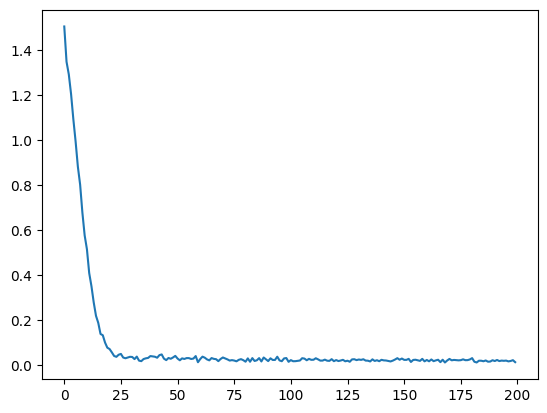

In [18]:
loss = metrics['loss']
epochs = np.arange(len(loss))

import matplotlib.pyplot as plt

plt.plot(epochs, loss)
plt.show()

In [26]:
inputs_batch, _, traj_batch = sample_obs_modelling_batch(jax.random.PRNGKey(0), return_traj=True)
obs_pred = model.apply(trainer_state.train_state.params, inputs_batch)
pred_action_dist, _ = pretrained_policy(obs_pred)
pred_action_dist.probs[0].round()

Array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [27]:
(pred_action_dist.probs.argmax(axis=-1) == traj_batch.action).mean()

Array(0.99250007, dtype=float32)

In [ ]:
inputs_batch, _, traj_batch = sample_obs_modelling_batch(jax.random.PRNGKey(0), return_traj=True)
obs_pred = model.apply(trainer_state.train_state.params, inputs_batch)
pred_action_dist, _ = pretrained_policy(obs_pred)
pred_action_dist.probs[0].round()
(pred_action_dist.probs.argmax(axis=-1) == traj_batch.action).mean()

In [82]:
discriminator = Discriminator(4 * hidden_size)
obs_model = ObsModel(obs_size, 4 * hidden_size)


from poclaps.train.losses import categorical_cross_entropy
from typing import Any, List, Tuple, Callable
from flax.training.train_state import TrainState
from flax import core
from flax import struct
import optax

from poclaps.train.training_cb import TrainerCallback


def create_discriminator_sample(obs_model_params, batch_inputs):
    # compute obs preds
    *_, obs = batch_inputs
    steps, n_envs, obs_dim = obs.shape
    batch_size = steps * n_envs
    obs_preds = obs_model.apply(obs_model_params, batch_inputs)
    obs_preds = obs_preds.reshape((batch_size, obs_dim))
    obs_batch = obs.reshape((batch_size, obs_dim))

    # compute inputs and labels
    labels = jnp.concatenate([jnp.zeros(batch_size),
                              jnp.ones(batch_size)])
    obs_inputs = jnp.concatenate([obs_batch, obs_preds], axis=0)

    return obs_inputs, labels


def compute_discriminator_loss(params, inputs):
    discriminator_params, obs_model_params = params
    obs_inputs, labels = create_discriminator_sample(obs_model_params, inputs)
    label_pred = discriminator.apply(discriminator_params, obs_inputs)
    return optax.losses.sigmoid_binary_cross_entropy(label_pred, labels).mean()


def compute_adv_obs_model_loss(params, inputs):
    discriminator_params, obs_model_params = params

    # compute action preds loss
    obs_preds = obs_model.apply(obs_model_params, inputs)
    pred_action_dist, _ = pretrained_policy(obs_preds)
    actions, *_ = inputs
    act_pred_loss = categorical_cross_entropy(
        pred_action_dist.logits, actions
    ).mean()

    # compute adversarial loss
    discr_pred = discriminator.apply(
        discriminator_params, obs_preds
    )
    discr_labels = jnp.ones_like(discr_pred)
    adv_loss = optax.losses.sigmoid_binary_cross_entropy(discr_pred, discr_labels).mean()

    adv_factor = 0.5

    return act_pred_loss + adv_factor * adv_loss


class AdvObsModellingTrainState(struct.PyTreeNode):
    step: int
    rng: jnp.ndarray
    tx: optax.GradientTransformation = struct.field(pytree_node=False)

    # obs model
    obs_model_apply_fn: Callable = struct.field(pytree_node=False)
    obs_model_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    obs_model_opt_state: optax.OptState = struct.field(pytree_node=True)

    # discriminator
    discriminator_apply_fn: Callable = struct.field(pytree_node=False)
    discriminator_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    discriminator_opt_state: optax.OptState = struct.field(pytree_node=True)


class AdversarialObsModellingTrainer:

    def __init__(self,
                 obs_model: ObsModel,
                 discriminator: Discriminator,
                 config: dict,
                 callback: TrainerCallback = None):
        self.obs_model = obs_model
        self.discriminator = discriminator
        self.callback = callback or TrainerCallback()
        self.config = config

        if 'seed' not in config:
            self.config['seed'] = 0
        if 'learning_rate' not in config:
            self.config['learning_rate'] = 1e-3
        if 'discriminator_updates_per_step' not in config:
            self.config['discriminator_updates_per_step'] = 10
        if 'obs_model_updates_per_step' not in config:
            self.config['obs_model_updates_per_step'] = 10

    def update_obs_model(self, tx, opt_state, params, inputs):
        _, obs_model_params = params
        loss, (_, grad) = jax.value_and_grad(compute_adv_obs_model_loss)(params, inputs)
        updates, new_opt_state = tx.update(grad, opt_state)
        new_variables = optax.apply_updates(obs_model_params, updates)
        return loss, new_variables, new_opt_state

    def update_discriminator(self, tx, opt_state, params, inputs):
        discriminator_params, _ = params
        loss, (grad, _) = jax.value_and_grad(compute_discriminator_loss)(params, inputs)
        updates, new_opt_state = tx.update(grad, opt_state)
        new_variables = optax.apply_updates(discriminator_params, updates)
        return loss, new_variables, new_opt_state

    def train_step(self, train_state: AdvObsModellingTrainState) -> AdvObsModellingTrainState:
        rng, _rng = jax.random.split(train_state.rng)
        inputs, metrics = sample_obs_modelling_batch(_rng)

        metrics = {
            f'sample/{k}': v for k, v in metrics.items()
        }

        def run_obs_model_substep(substep_state, _):
            obs_model_params, opt_state = substep_state
            params = (train_state.discriminator_params, obs_model_params)
            loss, new_params, new_opt_state = self.update_obs_model(
                train_state.tx, opt_state, params, inputs
            )
            return (new_params, new_opt_state), loss
        
        (new_obs_model_params, new_obs_model_opt_state), obs_model_loss = jax.lax.scan(
            run_obs_model_substep,
            (train_state.obs_model_params, train_state.obs_model_opt_state),
            None,
            self.config['obs_model_updates_per_step']
        )
        metrics['train/obs_model_loss'] = obs_model_loss.mean()

        def run_discriminator_substep(substep_state, _):
            discr_params, opt_state = substep_state
            params = (discr_params, new_obs_model_params)
            loss, new_discr_params, new_opt_state = self.update_discriminator(
                train_state.tx, opt_state, params, inputs
            )
            return (new_discr_params, new_opt_state), loss

        (new_discr_params, new_discr_opt_state), discr_loss = jax.lax.scan(
            run_discriminator_substep,
            (train_state.discriminator_params, train_state.discriminator_opt_state),
            None,
            self.config['discriminator_updates_per_step']
        )
        metrics['train/discriminator_loss'] = discr_loss.mean()

        new_params = (new_discr_params, new_obs_model_params)
        metrics.update(self.compute_eval_metrics(new_params, inputs))

        jax.experimental.io_callback(
            self.callback.on_iteration_end, None,
            train_state.step, train_state, metrics
        )

        train_state = train_state.replace(
            rng=rng,
            step=train_state.step + 1,
            obs_model_params=new_obs_model_params,
            obs_model_opt_state=new_obs_model_opt_state,
            discriminator_params=new_discr_params,
            discriminator_opt_state=new_discr_opt_state
        )

        return train_state, metrics

    def compute_eval_metrics(self, params: tuple, inputs: tuple) -> dict:
        eval_metrics = {}

        discr_params, obs_model_params = params
        
        obs_preds = self.obs_model.apply(obs_model_params, inputs)
        actions, msgs, dones, obs = inputs
        eval_metrics['eval/obs_pred_err'] = jnp.square(obs_preds - obs).mean()

        pred_action_dist, _ = pretrained_policy(obs_preds)
        eval_metrics['eval/action_pred_acc'] = (
            (pred_action_dist.probs.argmax(axis=-1) == actions.argmax(axis=-1)).mean()
        )

        obs_inputs, labels = create_discriminator_sample(obs_model_params, inputs)
        label_pred = self.discriminator.apply(discr_params, obs_inputs)
        eval_metrics['eval/discr_acc'] = (
            ((label_pred > 0) == labels).mean()
        )

        return eval_metrics

    def train(self, n_steps: int) -> Tuple[AdvObsModellingTrainState, dict]:
        optimizer = optax.adam(self.config['learning_rate'])
        rng = jax.random.PRNGKey(self.config['seed'])

        rng, _rng = jax.random.split(rng)
        inputs, _ = sample_obs_modelling_batch(_rng)

        rng, _rng = jax.random.split(rng)
        obs_model_params = self.obs_model.init(_rng, inputs)
        obs_model_opt_state = optimizer.init(obs_model_params)

        rng, _rng = jax.random.split(rng)
        discr_inp, *_ = create_discriminator_sample(obs_model_params, inputs)
        discr_params = self.discriminator.init(_rng, discr_inp)
        discr_opt_state = optimizer.init(discr_params)

        init_train_state = AdvObsModellingTrainState(
            step=0,
            rng=rng,
            tx=optimizer,
            obs_model_apply_fn=self.obs_model.apply,
            obs_model_params=obs_model_params,
            obs_model_opt_state=obs_model_opt_state,
            discriminator_apply_fn=self.discriminator.apply,
            discriminator_params=discr_params,
            discriminator_opt_state=discr_opt_state,
        )

        self.callback.on_train_begin(self.config)

        try:
            train_results = jax.lax.scan(
                jax.jit(lambda s, _: self.train_step(s)),
                init_train_state, None, n_steps
            )
        finally:
            self.callback.on_train_end(train_results)

        return train_results

In [83]:
from poclaps.train.wandb_cb import WandbCallback


cb = WandbCallback()
config = {
    'seed': 0,
    'learning_rate': 1e-4,
    'discriminator_updates_per_step': 10,
    'obs_model_updates_per_step': 10,
    'wandb_entity': 'drcope',
    'wandb_project': 'poclaps-obs-modelling',
    'wandb_mode': 'online',
}
aom_trainer = AdversarialObsModellingTrainer(obs_model, discriminator, config, cb)

In [84]:
aom_state, train_metrics = aom_trainer.train(500)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Logged in to wandb using secrets/wandb_api_key.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/action_pred_acc,██▇████▁███████████▅██████▄█▄▄▄▄▄▄▄▃▃▄▄▄
eval/discr_acc,█▅▁▇▁▇█▅█████████▇█▅██▆█▇▇▆█████████████
eval/obs_pred_err,▁▂▂▂▇▂▂▁▂▂▁▁▁▁▁▁▁▃█▅▄▄▄▄▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄
sample/mean_episode_len,█▄▅▄▄▄▄▄▇█▄▃▄▆▅▆▄▅▄▆▄▄▅▆▅▁▃▄▆▆▅▄▅▄▄▄▅▅▆▅
sample/mean_reward,▁▅▄▅▅▅▅▅▂▁▅▆▅▃▄▃▅▄▅▃▅▅▄▃▄█▆▅▃▃▄▅▄▅▅▅▄▄▃▄
sample/n_episodes,▁▄▄▅▅▅▅▅▂▁▅▅▅▃▄▃▅▄▅▃▅▅▃▃▄█▆▄▃▂▄▅▄▅▅▅▄▄▃▄
train/discriminator_loss,▄▃█▂▇▂▁▃▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/obs_model_loss,▁▂▁▁▃▂▃▃▄▄▅▅▅▅▆▆▆█▄▃▃▄▂▄▆▄▅▄▅▆▆▇▇▇▇█████
eval/action_pred_acc,0.7495
eval/discr_acc,1.0
eval/obs_pred_err,0.27298


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/action_pred_acc,▅▇▅▄▅▆█▆▆▆▄▄▅█▁▆▃▄▅▄▅▇▅▄▅▆▄▅▆▄▄▆▅▄▄▆▅▆▂▅
eval/discr_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/obs_pred_err,▄▄▂▁▁▁▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███████████
sample/mean_episode_len,█▄▅▃▃▃▅▂▄▅▁▄▆▅▆▃▄▄▆▄▄▅▆▃▄▆▅▅▆▇▅▅▅▄▄▅▆▄▃▅
sample/mean_reward,▁▅▄▆▆▆▄▇▅▄█▅▃▄▃▆▅▅▃▅▅▄▃▆▅▃▄▄▃▂▄▄▄▅▅▄▃▅▆▄
sample/n_episodes,▁▅▄▅▅▅▄▇▅▃█▅▃▃▃▆▅▅▃▅▅▃▃▆▅▃▃▄▂▂▄▄▃▅▄▄▃▅▅▄
train/discriminator_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/obs_model_loss,█▂▂▂▂▁▁▁▁▁▂▂▁▁▂▁▂▂▁▂▂▁▂▂▁▁▂▂▁▂▂▁▂▂▂▁▂▁▂▁
eval/action_pred_acc,0.996
eval/discr_acc,1.0
eval/obs_pred_err,0.34196


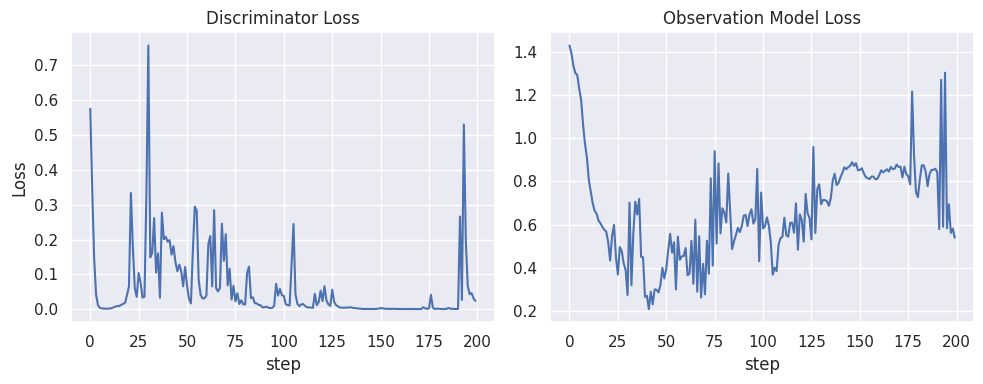

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

df = pd.DataFrame({
    'discriminator_loss': train_metrics['train/discriminator_loss'],
    'obs_model_loss': train_metrics['train/obs_model_loss'],
    'step': np.arange(train_metrics['train/discriminator_loss'].size)
})

sns.lineplot(df, x='step', y='discriminator_loss', ax=ax1)
ax1.set_title('Discriminator Loss')
ax1.set_ylabel('Loss')
sns.lineplot(df, x='step', y='obs_model_loss', ax=ax2)
ax2.set_title('Observation Model Loss')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()

In [75]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0))
obs_preds = obs_model.apply(aom_state.obs_model_params, inputs)

In [76]:
obs_preds[0].reshape((-1, 4, 5)).round(2), inputs[-1][0]

(Array([[[0.01      , 0.98999995, 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.98999995, 0.04      , 0.        , 0.        , 0.        ]],
 
        [[0.        , 0.98999995, 0.        , 0.        , 0.        ],
         [0.        , 1.        , 0.        , 0.        , 0.        ],
         [0.93      , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.97999996]],
 
        [[0.        , 0.98999995, 0.        , 0.        , 0.        ],
         [0.        , 1.        , 0.        , 0.        , 0.        ],
         [0.9       , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.97999996]],
 
        [[0.01      , 0.98999995, 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        

In [134]:
*_, obs_act = inputs
obs_test = jnp.concatenate([obs_preds[0], obs_act[0]])
discriminator.apply(aom_state.discriminator_params, obs_test)

Array([ 7.2419124,  7.2823973,  7.3928967,  7.267699 , -6.316666 ,
       -6.8062134, -7.373846 , -5.1030846], dtype=float32)

In [136]:
from poclaps.simple_gridworld_game import stringify_grid


def format_side_by_side(strings: Iterable[str]) -> str:
    """
    Format strings side by side. Assumes all strings have the same number of
    lines and each line has the same number of characters.
    """
    return '\n'.join([
        '\t'.join(lines)
        for lines in zip(*[g.split('\n') for g in strings])
    ])


def print_episode(goals, agent_pos):
    grid_strings = []

    for g, p in zip(goals, agent_pos):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p.tolist()): 'X', tuple(g.tolist()): 'G'
        })
        grid_strings.append(grid_str)

    print(format_side_by_side(grid_strings))



def print_episode_with_info(goals, agent_pos, actions, rewards):
    grid_strings = []

    for g, p, a, r in zip(goals, agent_pos, actions, rewards):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p.tolist()): 'X', tuple(g.tolist()): 'G'
        })
        line_0, *_ = grid_str.split('\n')
        info_str = f'Act: {a} | Reward: {r}'
        info_str += ' ' * (len(line_0) - len(info_str))
        grid_strings.append(f'{info_str}\n{grid_str}')

    print(format_side_by_side(grid_strings))


def print_episode_in_batch(ep_id: int,
                           traj_batch: Transition,
                           info: bool = False):

    env_state = traj_batch.env_state.env_state
    ep_ids = traj_batch.episode_id
    goals = env_state.goal_pos[ep_ids == ep_id]
    agent_pos = env_state.agent_pos[ep_ids == ep_id]
    actions = traj_batch.action[ep_ids == ep_id]
    rewards = traj_batch.reward[ep_ids == ep_id]

    if info:
        print_episode_with_info(goals, agent_pos, actions, rewards)
    else:
        print_episode(goals, agent_pos)

In [81]:
ep_id = 1
print_episode_in_batch(ep_id, traj_batch)

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   | X |   |   |	|   | X |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   | X |   |   |   |	| X |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
| G |   |   |   |   |	| G |   |   |   |   |	| G |   |   |   |   |	| G |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [133]:

forward_rrn = ScannedRNN()

N_ACTIONS = 5
actions_1h = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
msgs_1h = jax.nn.one_hot(msgs_batch, comm_policy.n_msgs)
feats = jnp.concatenate([actions_1h, msgs_1h], axis=-1)

forward_carry = forward_rrn.initialize_carry(feats.shape)

model_inputs = (feats, traj_batch.done)

variables = forward_rrn.init(jax.random.PRNGKey(0), forward_carry, model_inputs)

_, forward_embs = forward_rrn.apply(variables, forward_carry, model_inputs)

In [104]:
obs.shape

(500, 4, 20)

In [122]:
obs.shape

(500, 4, 20)